## Задание

Создайте автокодировщик, удаляющий черные квадраты в случайных областях изображений.

Алгоритм действий:
1. Возьмите базу картинок Mnist.
2. На картинках в случайных местах сделайте чёрные квадраты размера 8 на 8.
3. Создайте и обучите автокодировщик восстанавливать оригинальные изображения из "зашумленных" квадратом изображений.
4. Добейтесь MSE < 0.0070 на тестовой выборке

## Импорт библиотек

In [23]:
# Отображение
import matplotlib.pyplot as plt

# Для работы с тензорами
import numpy as np

# Класс создания модели
from tensorflow.keras.models import Model

# Для загрузки данных
from tensorflow.keras.datasets import mnist

# Необходимые слои
from tensorflow.keras.layers import Input, Conv2DTranspose, MaxPooling2D, Conv2D, BatchNormalization, Dropout, Cropping2D, Concatenate, LeakyReLU

# Оптимизатор
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.regularizers import l2

## Данные

In [24]:
# Загрузка данных
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [25]:
# Нормализация данных
X_train = X_train.astype('float32')/255.
X_test = X_test.astype('float32')/255.

# Изменение формы входных данных для подачи в сверточную нейронную сеть
X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

In [26]:
# Функция для добавления черных квадратов
def add_black_squares(images, square_size=8):
    noisy_images = np.copy(images)
    for i in range(len(noisy_images)):
        x = np.random.randint(0, 28 - square_size)
        y = np.random.randint(0, 28 - square_size)
        noisy_images[i, x:x+square_size, y:y+square_size, :] = 0
    return noisy_images

In [27]:
# Создаем зашумленные данные
noisy_X_train = add_black_squares(X_train)
noisy_X_test = add_black_squares(X_test)

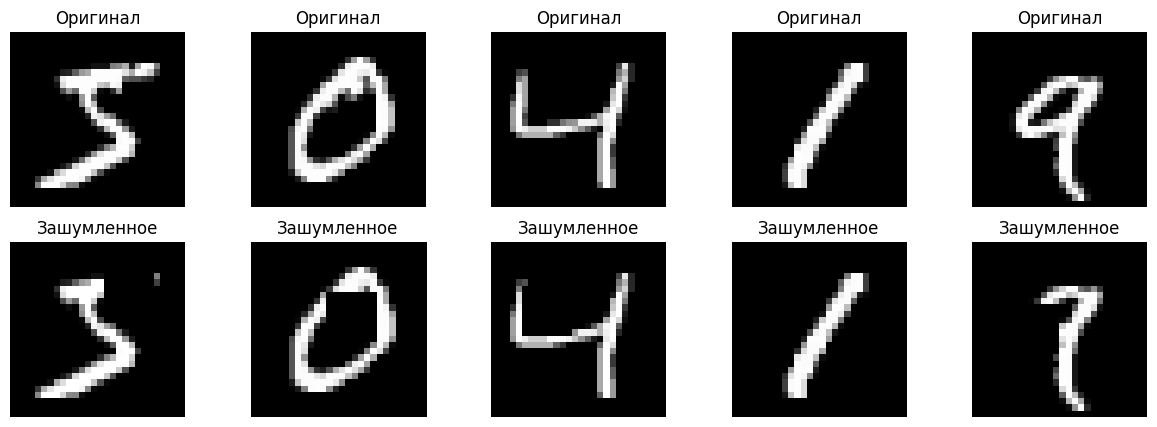

In [28]:
# Визуализация
def plot_examples(original, noisy, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        # Оригинал
        ax = plt.subplot(2, n, i+1)
        plt.imshow(original[i].squeeze(), cmap='gray')
        plt.title("Оригинал")
        plt.axis('off')

        # Зашумленное
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(noisy[i].squeeze(), cmap='gray')
        plt.title("Зашумленное")
        plt.axis('off')
    plt.show()

plot_examples(X_train, noisy_X_train)

#Создаем автокодировщик

In [29]:
# Архитектура автокодировщика
def create_advanced_autoencoder(input_shape):
    inputs = Input(shape=input_shape)

    # Энкодер
    x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x1 = BatchNormalization()(x1)
    x1 = LeakyReLU(alpha=0.1)(x1)
    p1 = MaxPooling2D((2, 2), padding='same')(x1)

    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(alpha=0.1)(x2)
    p2 = MaxPooling2D((2, 2), padding='same')(x2)

    # Центральный блок
    x3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    x3 = BatchNormalization()(x3)
    x3 = LeakyReLU(alpha=0.1)(x3)
    x3 = Dropout(0.3)(x3)

    # Декодер с правильными размерами для конкатенации
    u1 = UpSampling2D((2, 2))(x3)
    u1 = Conv2D(128, (2, 2), activation='relu', padding='same')(u1)  # Изменение размера
    u1 = Concatenate()([u1, x2])  # Теперь размеры совпадают

    x4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    x4 = BatchNormalization()(x4)
    x4 = LeakyReLU(alpha=0.1)(x4)

    u2 = UpSampling2D((2, 2))(x4)
    u2 = Conv2D(64, (2, 2), activation='relu', padding='same')(u2)  # Изменение размера
    u2 = Concatenate()([u2, x1])  # Теперь размеры совпадают

    x5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    x5 = BatchNormalization()(x5)
    x5 = LeakyReLU(alpha=0.1)(x5)

    outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x5)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model

model = create_advanced_autoencoder((28, 28, 1))
model.summary()

# Коллбэки
callbacks = [
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
]

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 28, 28, 64)     │            640 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 28, 28, 64)     │            256 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_15            │ (None, 28, 28, 64)     │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 14, 14, 64)     │              0 │ leaky_re_lu_15[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 14, 14, 128)    │         73,856 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 14, 14, 128)    │            512 │ conv2d_25[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_16            │ (None, 14, 14, 128)    │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 7, 7, 128)      │              0 │ leaky_re_lu_16[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 7, 7, 256)      │        295,168 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 7, 7, 256)      │          1,024 │ conv2d_26[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_17            │ (None, 7, 7, 256)      │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 7, 7, 256)      │              0 │ leaky_re_lu_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_6           │ (None, 14, 14, 256)    │              0 │ dropout_3[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)   

 Total params: 905,665 (3.45 MB)

 Trainable params: 904,385 (3.45 MB)

 Non-trainable params: 1,280 (5.00 KB)

# Обучение

In [30]:
# Обучение модели
history = model.fit(
    noisy_X_train, X_train,
    epochs=5,
    batch_size=256,
    shuffle=True,
    validation_data=(noisy_X_test, X_test),
    callbacks=callbacks
)


Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0426

235/235 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - loss: 0.0425 - val_loss: 0.0455 - learning_rate: 5.0000e-04
Epoch 2/5
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0047

235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - loss: 0.0047 - val_loss: 0.0216 - learning_rate: 5.0000e-04
Epoch 3/5
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0038

235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step - loss: 0.0038 - val_loss: 0.0061 - learning_rate: 5.0000e-04
Epoch 4/5
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0034

235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - loss: 0.0034 - val_loss: 0.0035 - learning_rate: 5.0000e-04
Epoch 5/5
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0031

235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - loss: 0.0031 - val_loss: 0.0034 - learning_rate: 5.0000e-04


In [31]:
# Определение ошибки
noisy_X_test = add_black_squares(X_test)  # Ваша функция
test_loss = model.evaluate(noisy_X_test, X_test, verbose=0)
print(f"New Test MSE: {test_loss:.7f}")

New Test MSE: 0.0033364


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
Диапазон значений в decoded_imgs: 4.595686e-05 0.9950126


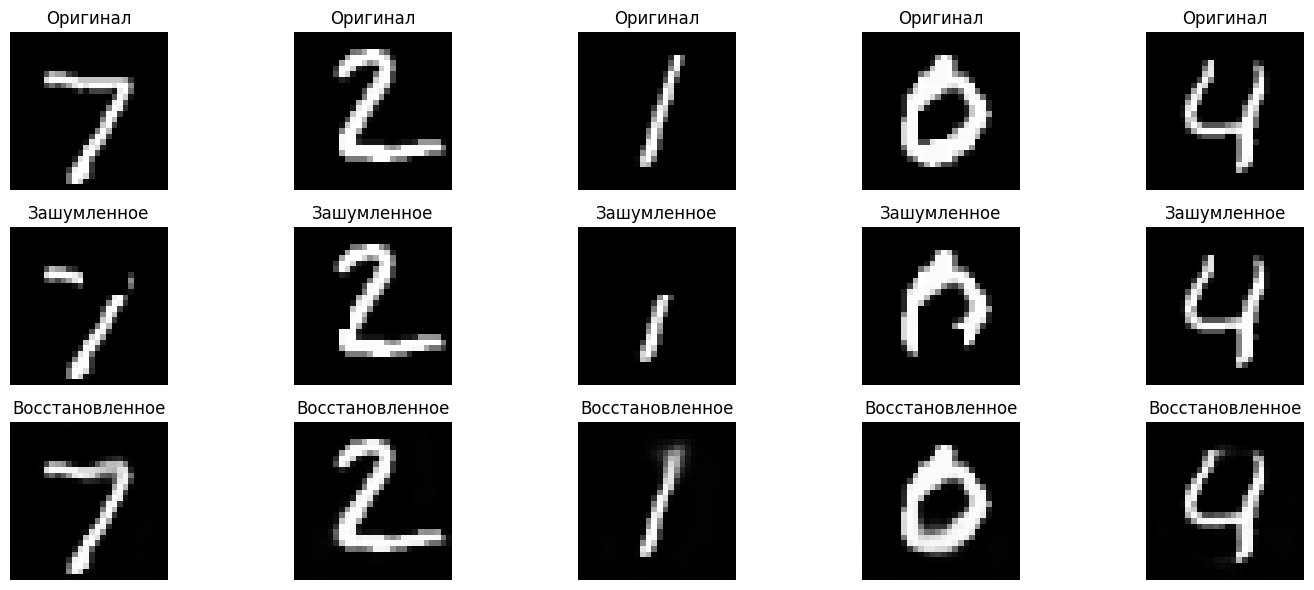

In [32]:
def plot_results(original, noisy, decoded, n=5):
    plt.figure(figsize=(15, 6))
    for i in range(n):
        # Оригинал
        plt.subplot(3, n, i+1)
        plt.imshow(original[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title("Оригинал")
        plt.axis('off')

        # Зашумленное
        plt.subplot(3, n, i+1+n)
        plt.imshow(noisy[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title("Зашумленное")
        plt.axis('off')

        # Восстановленное
        plt.subplot(3, n, i+1+2*n)
        plt.imshow(decoded[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title("Восстановленное")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Предсказание с проверкой данных
decoded_imgs = model.predict(noisy_X_test[:5])

# Проверка диапазона значений
print("Диапазон значений в decoded_imgs:", decoded_imgs.min(), decoded_imgs.max())
plot_results(X_test[:5], noisy_X_test[:5], decoded_imgs)